In [1]:
import os
import sys
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor
from torch.utils.data import DataLoader
import numpy as np
import einops
import wandb
import plotly.express as px
from pathlib import Path
import itertools
import random
from IPython.display import display
import wandb
from jaxtyping import Float, Int, Bool, Shaped, jaxtyped
from typing import Union, Optional, Tuple, Callable, Dict
import typeguard
from functools import partial
import copy
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML
import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import HookedRootModule, HookPoint
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache
from tqdm.notebook import tqdm
from dataclasses import dataclass
from rich import print as rprint
import pandas as pd
import torch
import matplotlib.pyplot as plt

import circuits.eval_sae_as_classifier as eval_sae
import circuits.analysis as analysis
import circuits.eval_board_reconstruction as eval_board_reconstruction
import circuits.get_eval_results as get_eval_results
import circuits.f1_analysis as f1_analysis
import circuits.utils as utils
import circuits.pipeline_config as pipeline_config
from circuits.dictionary_learning.dictionary import AutoEncoder, GatedAutoEncoder, AutoEncoderNew
import common
import chess_utils
#from plotly_utils import imshow
#from neel_plotly import scatter, line



device = t.device('cuda' if t.cuda.is_available() else 'cpu')
import pickle
with open('meta.pkl', 'rb') as picklefile:
    meta = pickle.load(picklefile)

/opt/conda/envs/chessgpt/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
autoencoder = common.load_autoencoder(device)
model = common.load_model(device)
train_dataset = common.get_train_dataset(device)

/opt/conda/envs/chessgpt/lib/python3.11/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading statistics aggregation dataset


In [3]:
encoded_inputs_tensor = t.stack([t.tensor(x) for x in train_dataset['encoded_inputs']]).to(device)
is_check = train_dataset['board_to_check_state'].squeeze(-1)

In [4]:

max_sae_activations = []
def get_activation(name):
    def hook(model, input, output):
        encoded_activations = autoencoder.encode(output[0]) # batch_size x len_seq x n_features_sae
        collapsed = (encoded_activations.max(dim=0).values.max(dim=0).values)
        max_sae_activations.append(collapsed.unsqueeze(0))
    return hook

t.set_grad_enabled(False)
activation_handle = model.transformer.h[5].register_forward_hook(get_activation(f"resid_stream_{5}"))
num_batches = 100
batch_size = len(encoded_inputs_tensor) // num_batches
if device == 'cpu':
    num_batches = 1
    batch_size = 1
    
for i in range(num_batches):
    model(encoded_inputs_tensor[i*batch_size:(i+1)*batch_size])
    t.cuda.empty_cache()
activation_handle.remove()


In [5]:
max_activations = t.concat(max_sae_activations).max(dim=0).values

In [6]:
aggregation_results = common.get_aggregation_results(1000)
formatted_results = common.get_formatted_results(aggregation_results)
features_for_check_state = common.get_true_feature_indices(formatted_results, "board_to_check_state")
features_for_check_state = features_for_check_state.to(device)

In [7]:
relevant_sae_activations = []
def get_activation(name, relevant_features):
    def hook(model, input, output):
        encoded_activations = autoencoder.encode(output[0]) # batch_size x len_seq x n_features_sae
        relevant_sae_activations.append(encoded_activations[:, :, features_for_check_state])
    return hook

t.set_grad_enabled(False)
activation_handle = model.transformer.h[5].register_forward_hook(get_activation(f"resid_stream_{5}", features_for_check_state))
num_batches = 100
batch_size = len(encoded_inputs_tensor) // num_batches
if device == 'cpu':
    num_batches = 1
    batch_size = 1
for i in range(num_batches):
    model(encoded_inputs_tensor[i*batch_size:(i+1)*batch_size])
    t.cuda.empty_cache()
activation_handle.remove()

In [8]:
all_relevant_sae_activations = t.concat(relevant_sae_activations, dim=0)
is_this_a_dot = (encoded_inputs_tensor == meta['stoi']['.']).to(device)

In [9]:
threshold = 0.2
activated_cases = t.where(all_relevant_sae_activations > threshold * max_activations[features_for_check_state], 1, 0)
activated_cases *= is_this_a_dot.unsqueeze(2)
# Most of the indices we have  are perfect classifiers when restricting to a place where a '.' is, but not all!
(is_check.squeeze(-1) * activated_cases).sum(dim=0).sum(dim=0)/activated_cases.sum(dim=0).sum(dim=0)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.5000, 1.0000,
        1.0000, 0.6667, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.5000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000], device='cuda:0')

Hypothesis #1: We can boost the logit for K by increasing activation of these features


In [52]:
def apply_is_a_dot_and_average(input):
    return (input * is_this_a_dot.unsqueeze(2)).sum(dim=0).sum(dim=0)/is_this_a_dot.sum(dim=0).sum(dim=0)


def initervene_activation(name, feature_index_list, strength):
    def hook(model, input, output):
        output_activations = output[0] # batch_size x len_seq x n_features_residual
        addition_vector = t.zeros_like(max_activations) # n_features_sae
        addition_vector[feature_index_list] = strength * max_activations[feature_index_list]
        output_activations += autoencoder.decode(addition_vector)
        return (output_activations, output[1])
    return hook
def get_all_logits(feature_list, strength):
    num_batches = 100
    batch_size = len(encoded_inputs_tensor) // num_batches
    baseline_logits_list = []
    intervened_logits_list = []
    for i in range(num_batches):
        baseline_logits = model(encoded_inputs_tensor[i*batch_size:(i+1)*batch_size]).logits
        baseline_logits_list.append(baseline_logits)
        activation_handle = model.transformer.h[5].register_forward_hook(initervene_activation(f"resid_stream_{5}", feature_list, strength))
        intervened_logits = model(encoded_inputs_tensor[i*batch_size:(i+1)*batch_size]).logits
        intervened_logits_list.append(intervened_logits)
        activation_handle.remove()
        t.cuda.empty_cache()

    combined_baseline_logits = t.concat(baseline_logits_list, dim=0)
    combined_intervened_logits = t.concat(intervened_logits_list, dim=0)
    diff_logits = combined_intervened_logits - combined_baseline_logits

    averaged_baseline_logits = apply_is_a_dot_and_average(combined_baseline_logits)
    averaged_intervened_logits = apply_is_a_dot_and_average(combined_intervened_logits)
    averaged_diff_logits = averaged_intervened_logits - averaged_baseline_logits
    return averaged_baseline_logits, averaged_intervened_logits, averaged_diff_logits


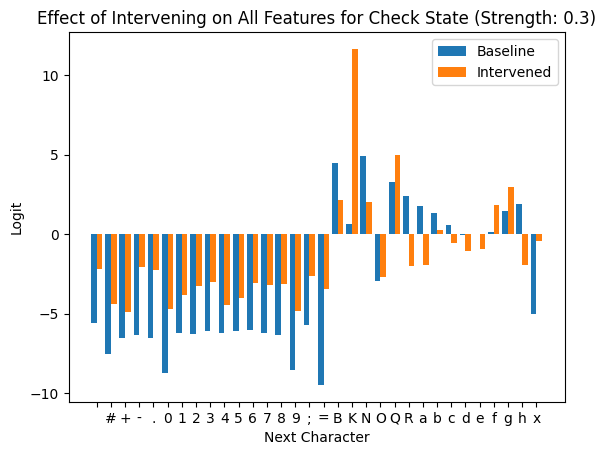

In [53]:
example_strength = 0.3
averaged_baseline_logits, averaged_intervened_logits, averaged_diff_logits = get_all_logits(features_for_check_state, example_strength)
X = [meta['itos'][i] for i in range(len(averaged_baseline_logits.cpu().numpy()))]
y = averaged_baseline_logits.cpu().numpy()
z = averaged_intervened_logits.cpu().numpy()
X_axis = np.arange(len(X)) 
  
plt.bar(X_axis - 0.2, y, 0.4, label = 'Baseline') 
plt.bar(X_axis + 0.2, z, 0.4, label = 'Intervened') 
  
plt.xticks(X_axis, X) 
plt.xlabel("Next Character") 
plt.ylabel("Logit") 
plt.title(f"Effect of Intervening on All Features for Check State (Strength: {example_strength})") 
plt.legend() 
plt.show() 


In [86]:
# Let's try to sweep over different strengths and perhaps separate out different features
path_for_dicts = 'data/'
averaged_baseline_logits_dict = t.load(f'{path_for_dicts}/averaged_baseline_logits_dict.pt')
averaged_intervened_logits_dict = t.load(f'{path_for_dicts}/averaged_intervened_logits_dict.pt')

for strength in np.linspace(-0.5, 1.5, 11):
    for feature_index in features_for_check_state:
        feature_index = feature_index.item()
        print(feature_index, strength)
        if (feature_index, strength) in averaged_baseline_logits_dict.keys():
            print('here')
            continue
        averaged_baseline_logits, averaged_intervened_logits, averaged_diff_logits = get_all_logits([feature_index], strength)
        averaged_baseline_logits_dict[(feature_index, strength)] = averaged_baseline_logits
        averaged_intervened_logits_dict[(feature_index, strength)] = averaged_intervened_logits

t.save(averaged_baseline_logits_dict, f'{path_for_dicts}/averaged_baseline_logits_dict.pt')
t.save(averaged_intervened_logits_dict, f'{path_for_dicts}/averaged_intervened_logits_dict.pt')
    

167 -0.5
here
228 -0.5
410 -0.5
614 -0.5
706 -0.5
746 -0.5
765 -0.5
1218 -0.5
1396 -0.5
1610 -0.5
1673 -0.5
1810 -0.5
1858 -0.5
1878 -0.5
1969 -0.5
2048 -0.5
2252 -0.5
2303 -0.5
2381 -0.5
2388 -0.5
2533 -0.5
2595 -0.5
2794 -0.5
2960 -0.5
3133 -0.5
3168 -0.5
3240 -0.5
3517 -0.5
3814 -0.5
3911 -0.5
167 -0.3
228 -0.3
410 -0.3
614 -0.3
706 -0.3
746 -0.3
765 -0.3
1218 -0.3
1396 -0.3
1610 -0.3
1673 -0.3
1810 -0.3
1858 -0.3
1878 -0.3
1969 -0.3
2048 -0.3
2252 -0.3
2303 -0.3
2381 -0.3
2388 -0.3
2533 -0.3
2595 -0.3
2794 -0.3
2960 -0.3
3133 -0.3
3168 -0.3
3240 -0.3
3517 -0.3
3814 -0.3
3911 -0.3
167 -0.09999999999999998
228 -0.09999999999999998
410 -0.09999999999999998
614 -0.09999999999999998
706 -0.09999999999999998
746 -0.09999999999999998
765 -0.09999999999999998
1218 -0.09999999999999998
1396 -0.09999999999999998
1610 -0.09999999999999998
1673 -0.09999999999999998
1810 -0.09999999999999998
1858 -0.09999999999999998
1878 -0.09999999999999998
1969 -0.09999999999999998
2048 -0.09999999999999998


In [84]:
averaged_baseline_logits_dict.keys()

dict_keys([(167, -0.5)])

In [80]:
feature_index.item()

167